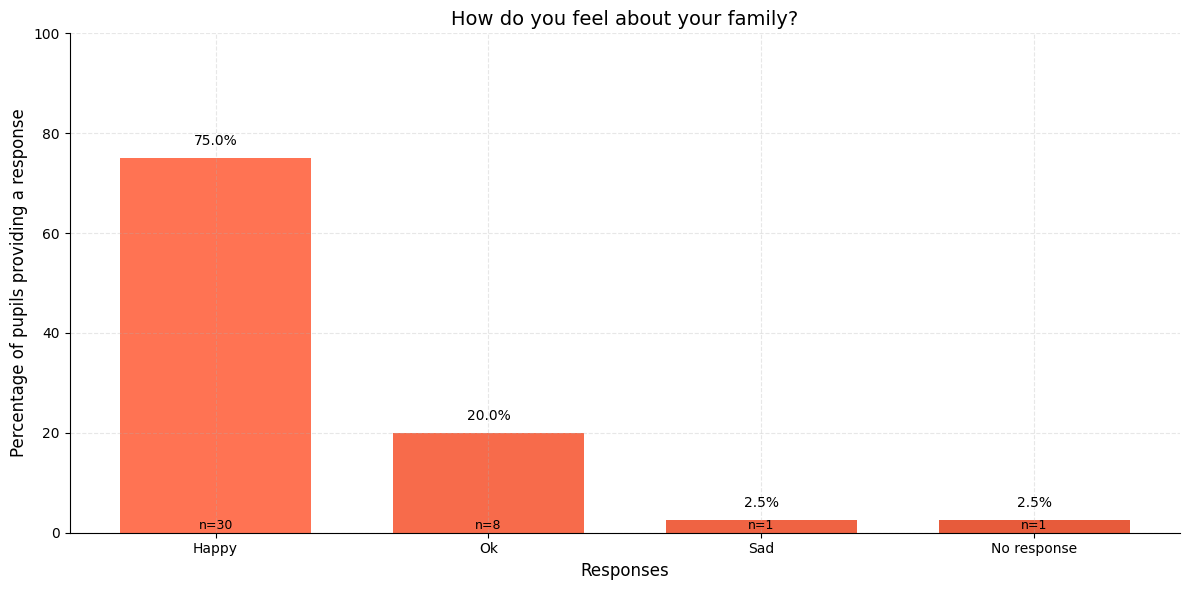

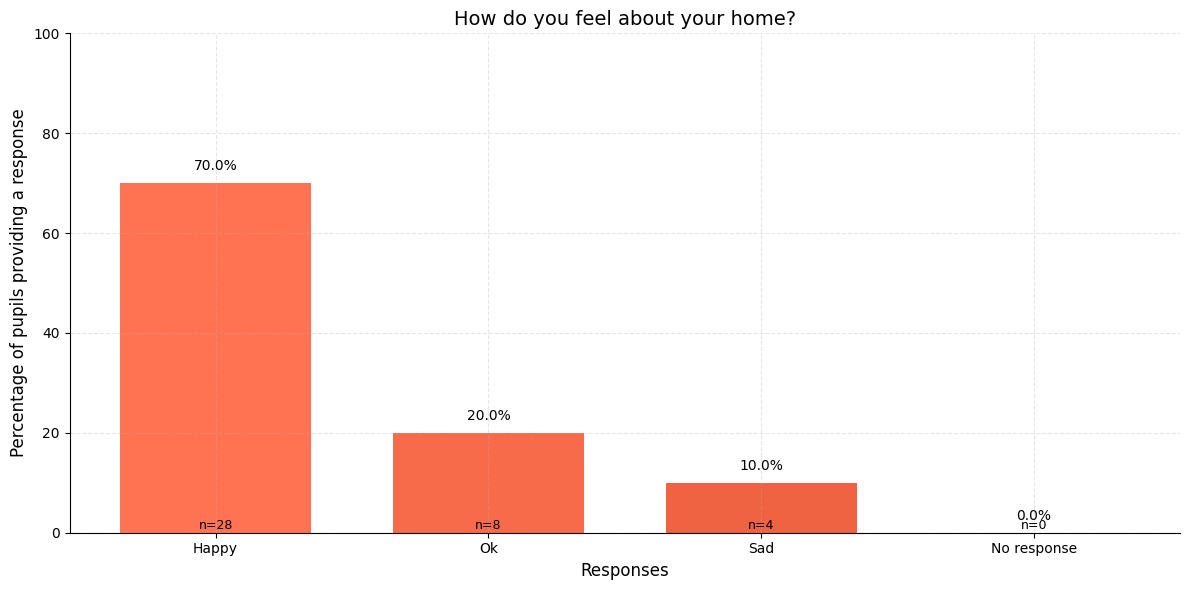

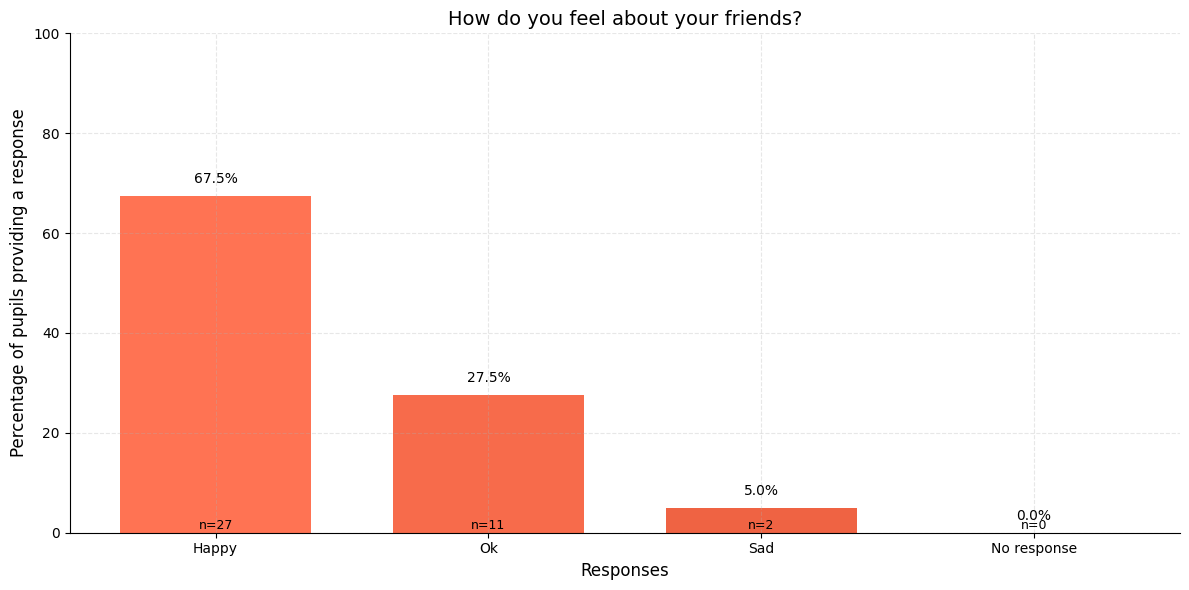

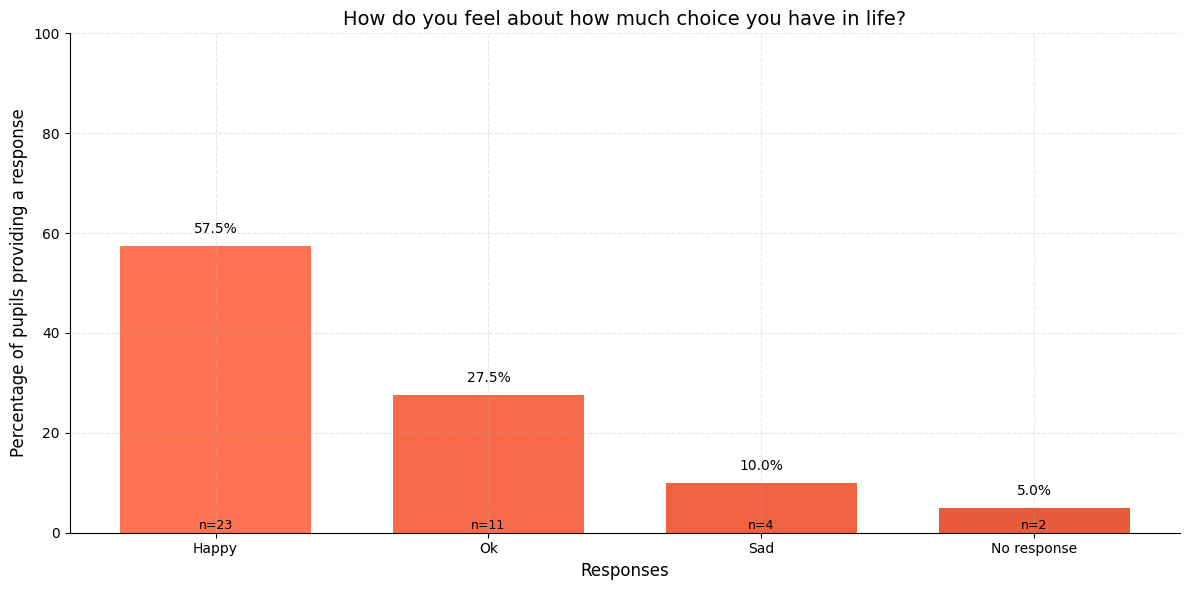

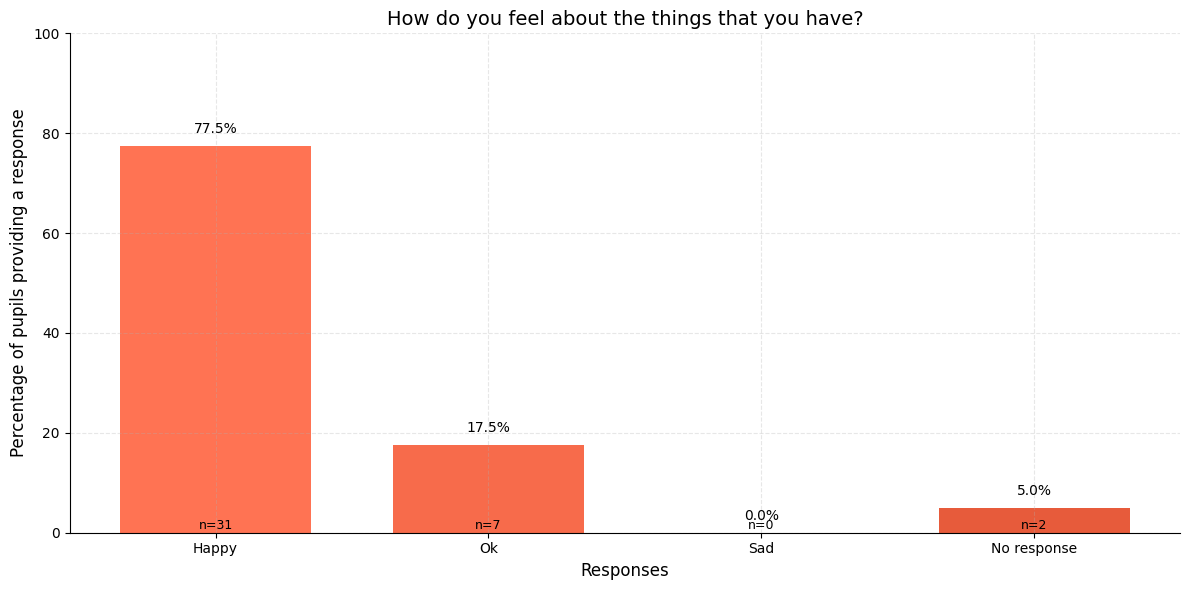

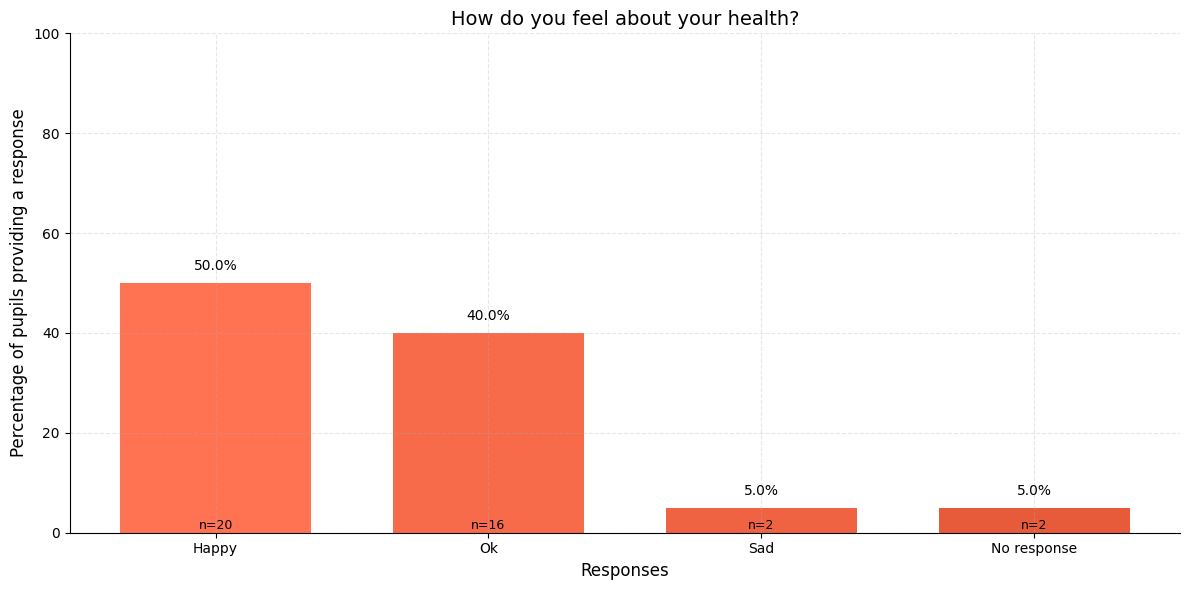

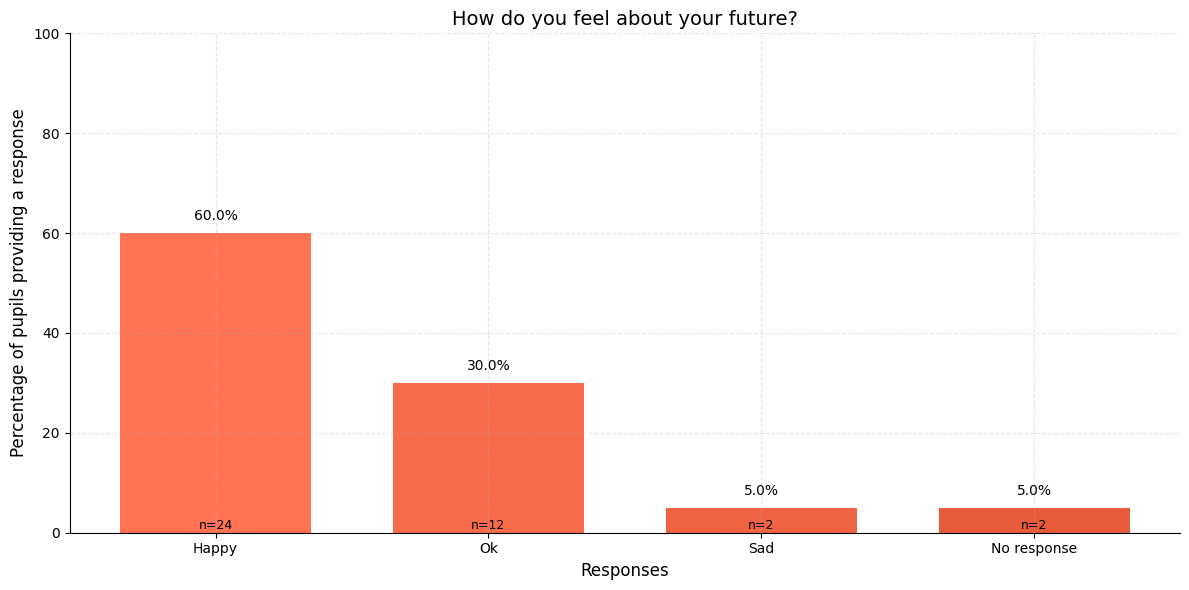

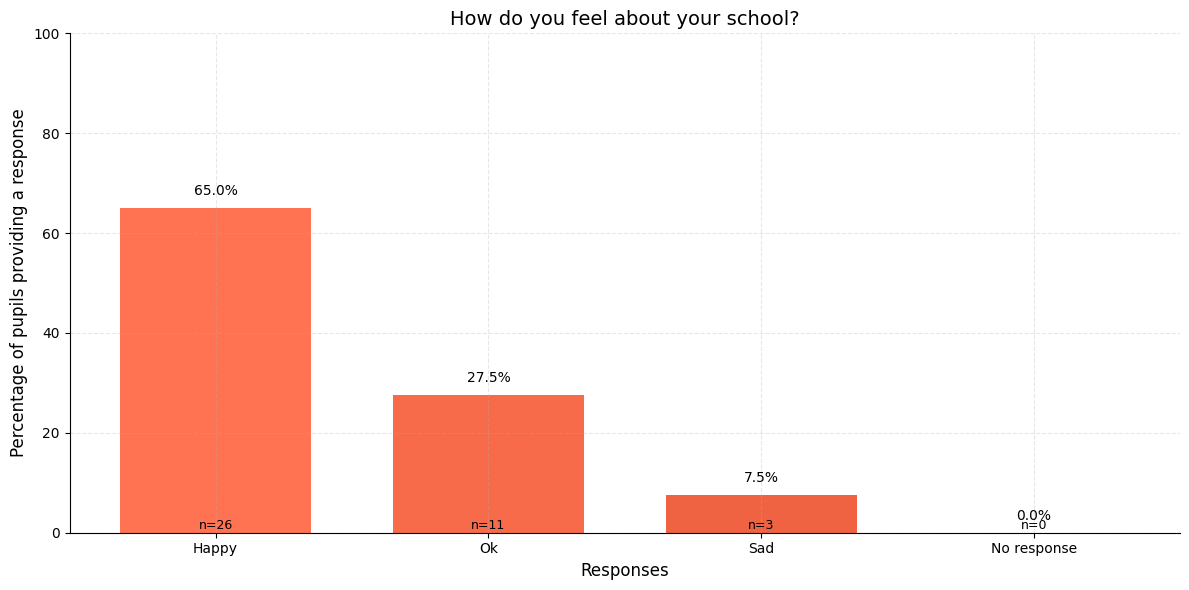

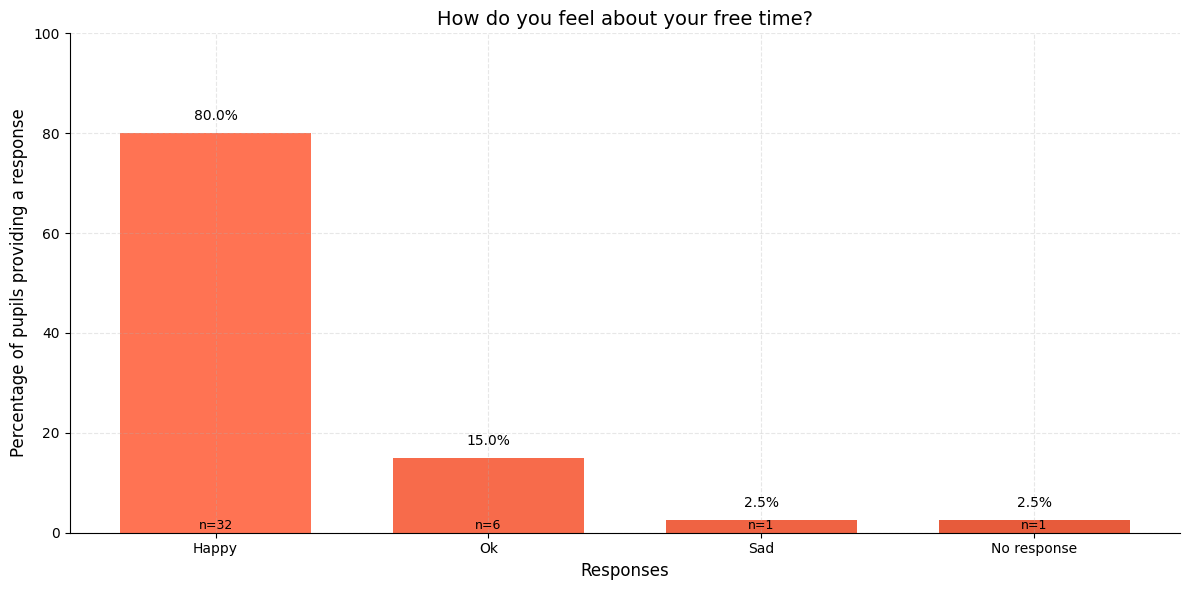

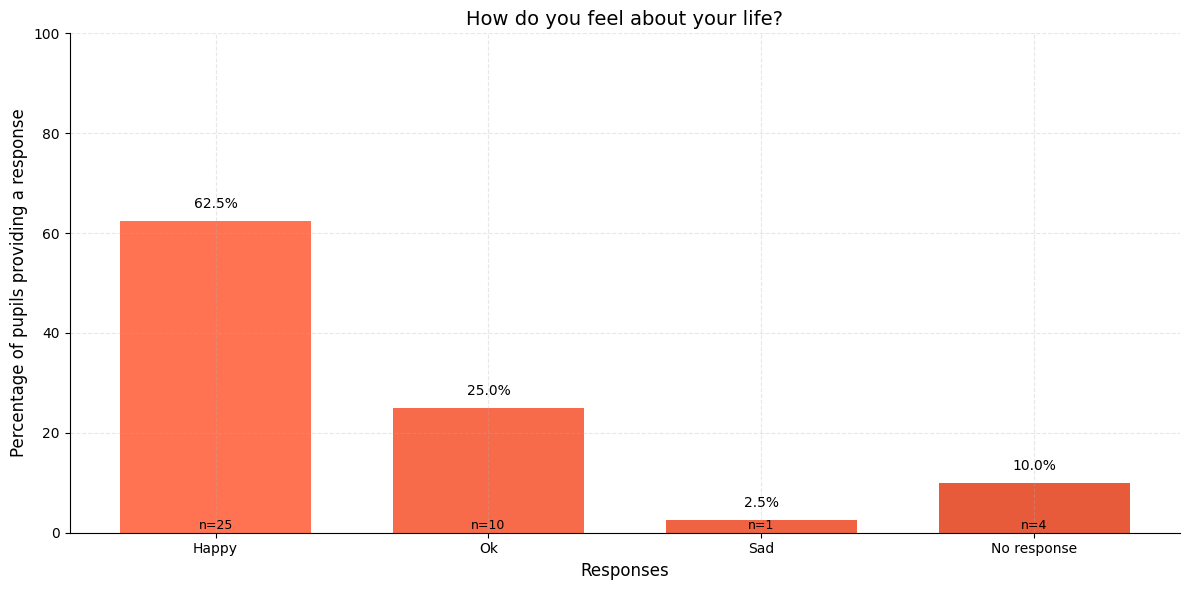

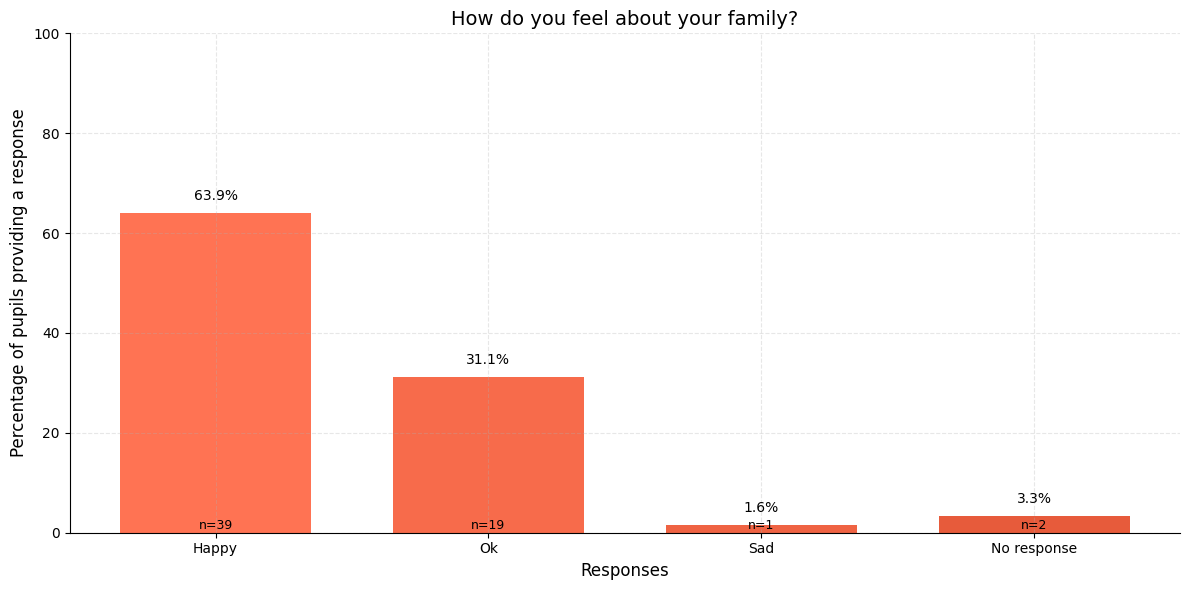

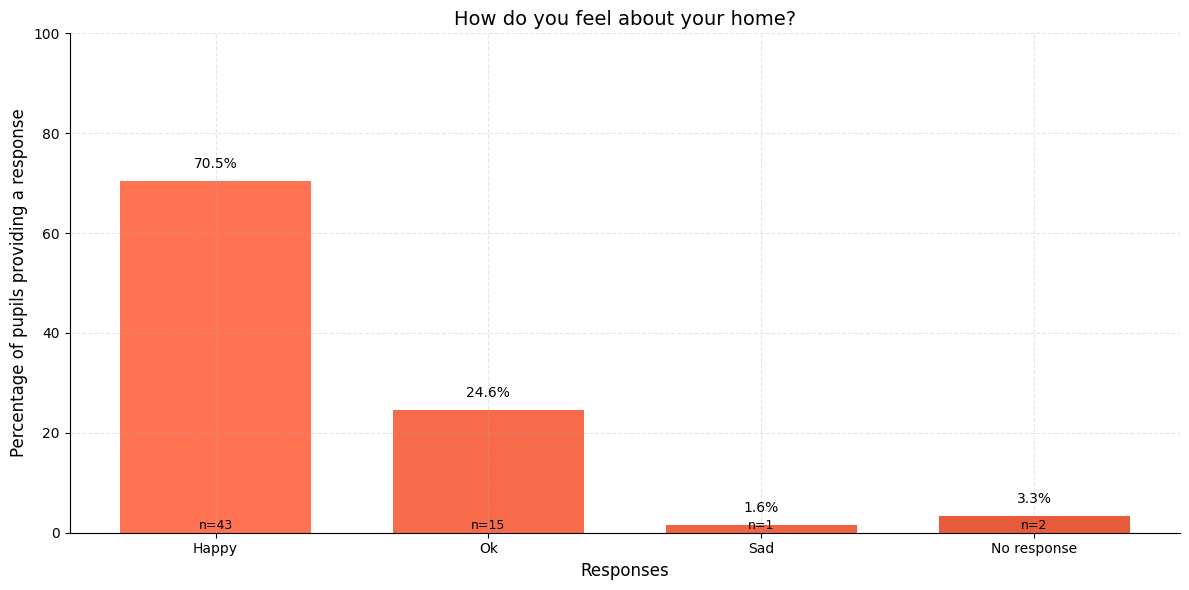

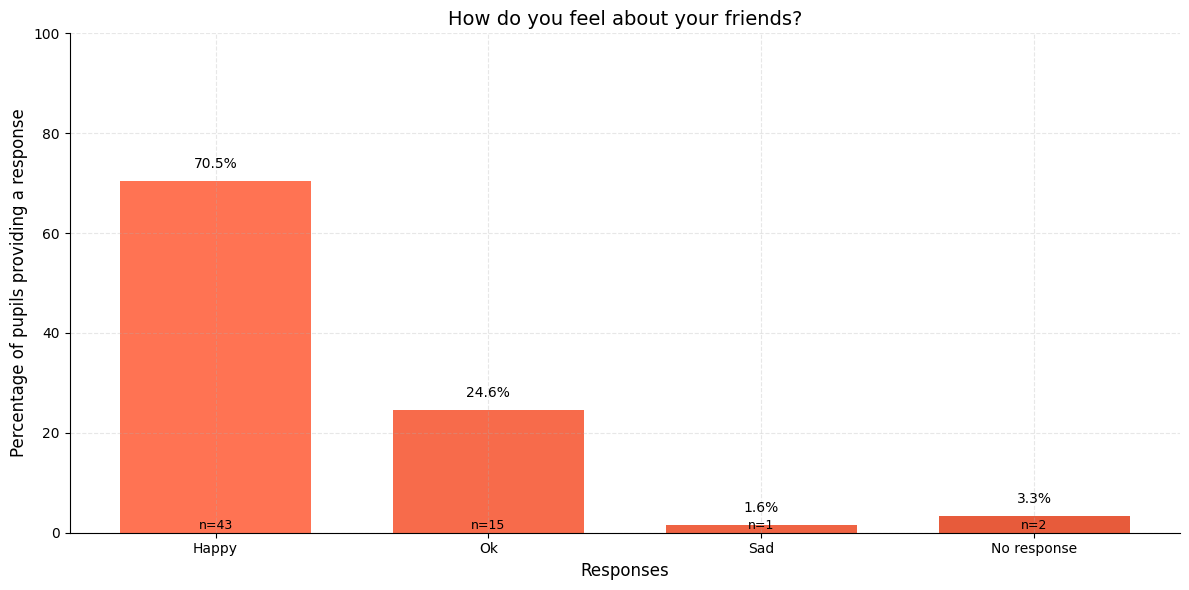

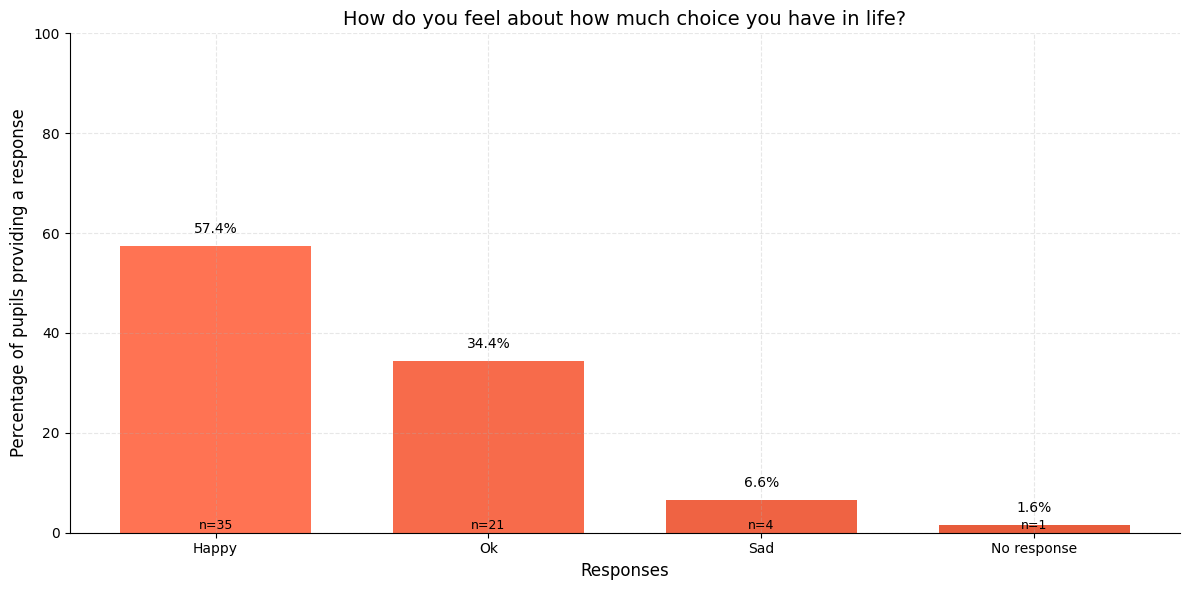

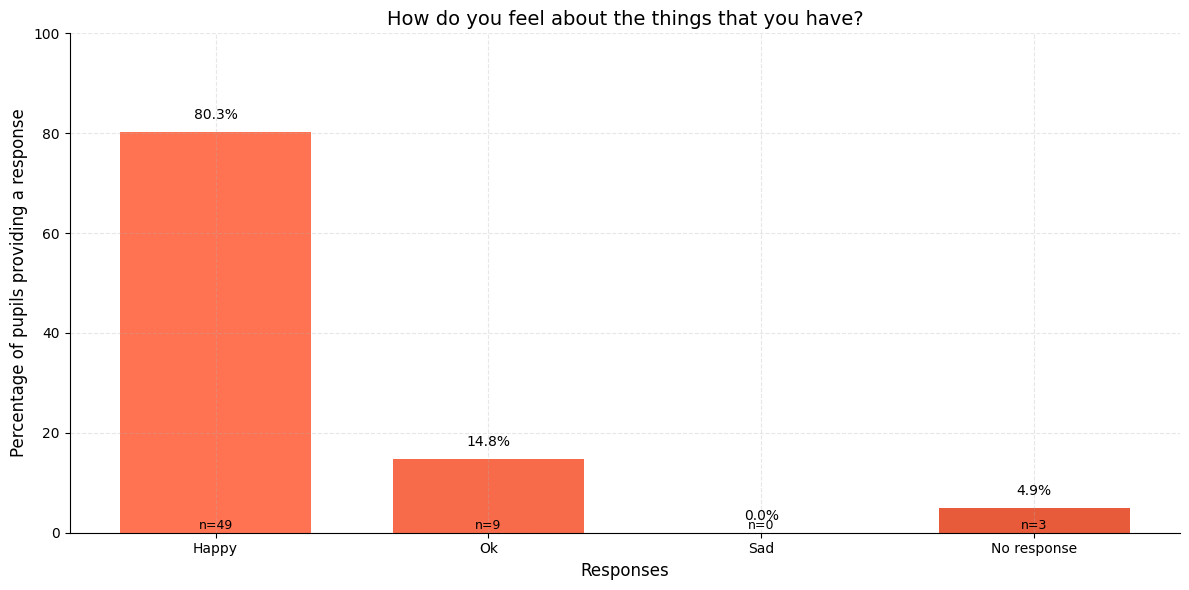

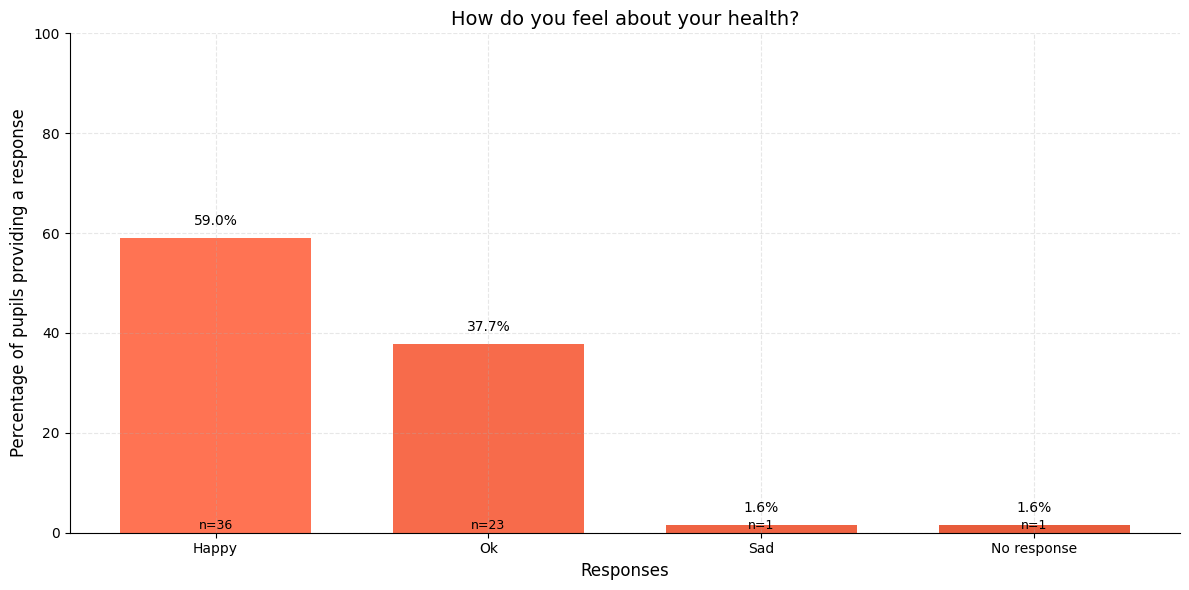

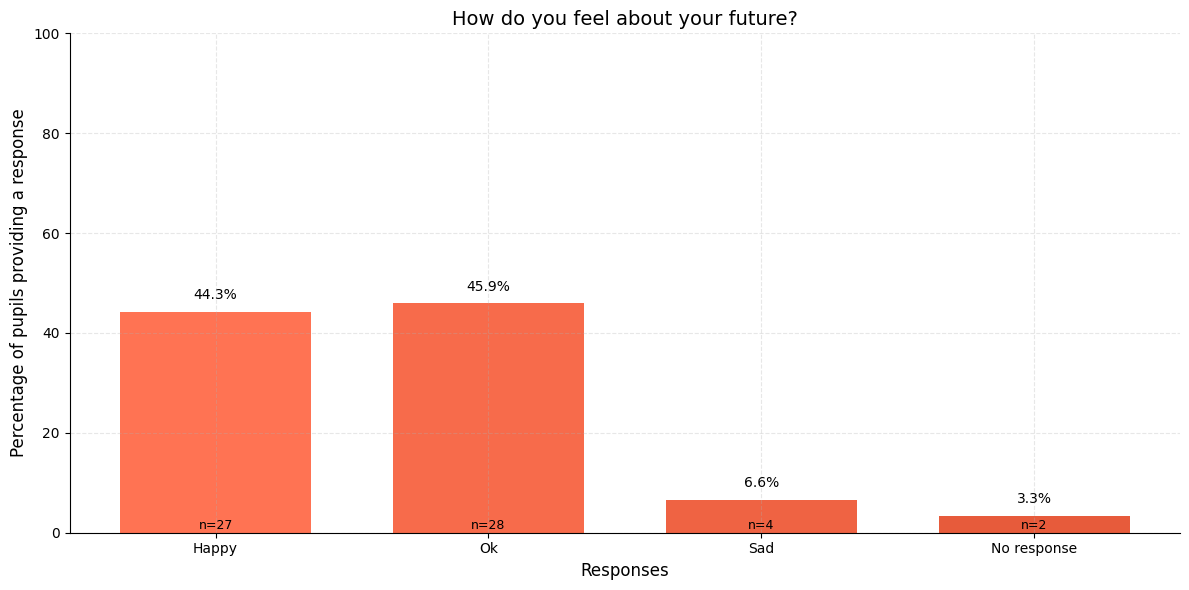

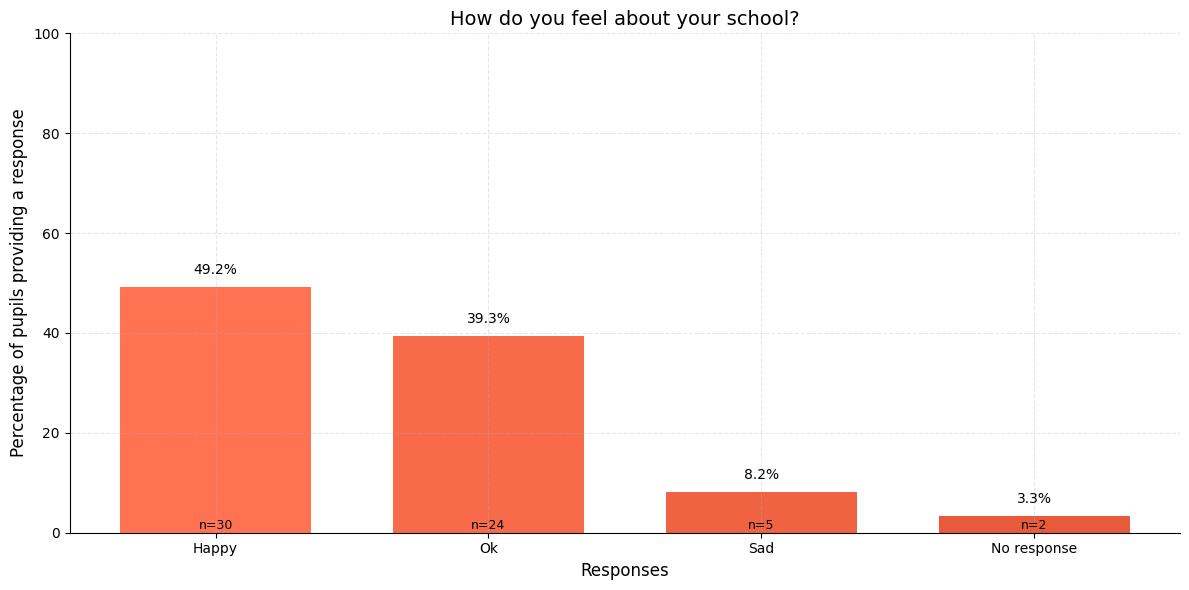

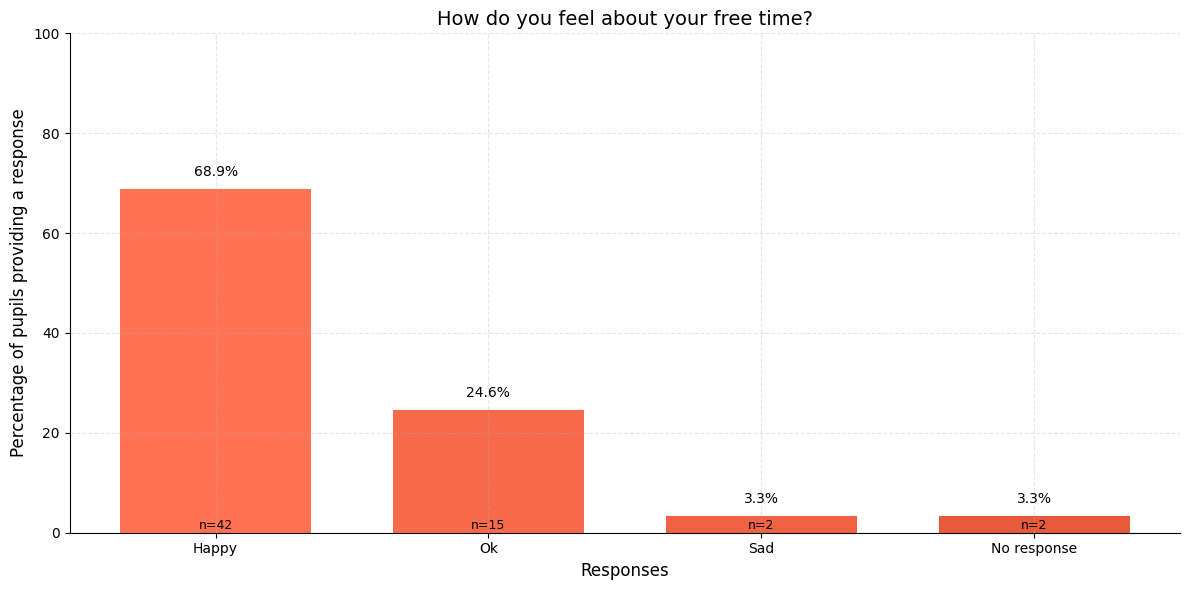

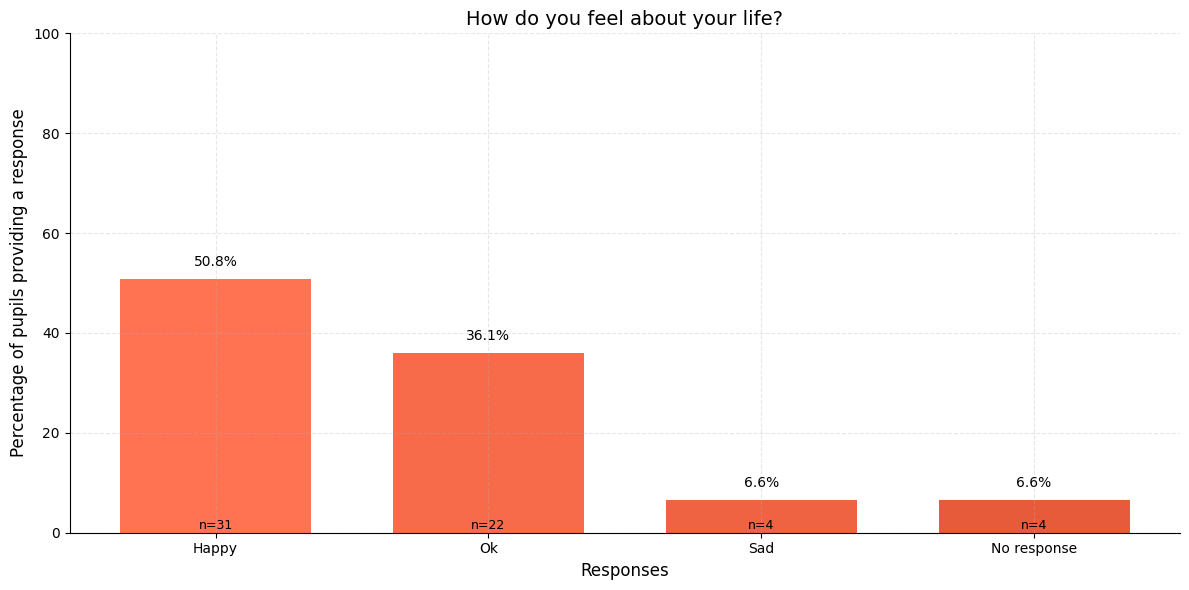

In [1]:
import ast
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load and preprocess the data
def load_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(
        "/Users/ellengoddard/Desktop/development-folder/beewell-graphs/kailo-beewell-graphs/data/real/symbol_nd_aggregate_responses.csv")

    # Clean column names (strip whitespace)
    df.columns = df.columns.str.strip()

    # Convert string representations of lists to actual lists
    def convert_to_list(column):
        return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Convert percentage, cat_lab, and count columns to lists
    df["percentage"] = convert_to_list(df["percentage"])
    df["cat_lab"] = convert_to_list(df["cat_lab"])
    df["count"] = convert_to_list(df["count"])  # Convert count to list

    # Drop rows with any missing data in essential columns
    df = df.dropna(subset=["percentage", "cat_lab", "count"])

    # Flatten the list columns
    expanded_rows = []
    for _, row in df.iterrows():
        max_length = max(len(row["cat_lab"]), len(row["percentage"]), len(row["count"]))
        for i in range(max_length):
            expanded_row = {
                "cat_lab": row["cat_lab"][i] if i < len(row["cat_lab"]) else None,
                "percentage": row["percentage"][i] if i < len(row["percentage"]) else None,
                "count": row["count"][i] if i < len(row["count"]) else None,
                "measure_lab": row["measure_lab"],
                "school_lab": row["school_lab"],
                "year_group_lab": row["year_group_lab"],
                "fsm_lab": row["fsm_lab"],
                "gender_lab": row["gender_lab"],
            }
            expanded_rows.append(expanded_row)

    expanded_df = pd.DataFrame(expanded_rows)

    # Ensure numeric types for percentages and counts
    expanded_df["percentage"] = pd.to_numeric(expanded_df["percentage"], errors="coerce")
    expanded_df["count"] = pd.to_numeric(expanded_df["count"], errors="coerce")

    # Drop rows with invalid or missing percentages and counts
    expanded_df = expanded_df.dropna(subset=["percentage", "count"])

    return expanded_df


# Generate incremental colours for the bars
def get_incremental_colors(n: int):
    base_color = (255, 80, 40)  # Orange-red color
    increment = 10
    colors = []
    for i in range(n):
        r = max(min(base_color[0] - i * increment, 255), 0)
        g = max(min(base_color[1] - i * increment, 255), 0)
        b = max(min(base_color[2] - i * increment, 255), 0)
        colors.append((r / 255, g / 255, b / 255)) 
    return colors  


# Plot the "All" category data
def plot_all_category_separately(df, categories, measure_lab, school_name, save_dir):
    # Filter data for "All" responses only
    all_data = df[(df["year_group_lab"] == "All") & (df["fsm_lab"] == "All") & (df["gender_lab"] == "All")]

    # Map percentage and count to categories directly
    percentages = all_data.set_index("cat_lab")["percentage"].reindex(categories, fill_value=0)
    counts = all_data.set_index("cat_lab")["count"].reindex(categories, fill_value=0)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(categories))
    bar_width = 0.7

    # Generate colours for the bars
    colors = get_incremental_colors(len(categories))

    # Plot bars
    bars = ax.bar(x, percentages, width=bar_width, color=colors, alpha=0.8)

# Annotate bars with percentage and count values
    y_offset_from_axis = 0.1  # Adjust this value to control the vertical position above the x-axis
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        n_responses = counts.iloc[i]

        # Annotate percentage at the top of the bar
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 2, f"{yval:.1f}%", ha="center", va="bottom", fontsize=10)

        # Annotate count just above the x-axis
        ax.text(
            bar.get_x() + bar.get_width() / 2, y_offset_from_axis, f"n={n_responses}", ha="center", va="bottom", fontsize=9
        )

    # Add labels and title
    ax.set_xlabel("Responses", fontsize=12)
    ax.set_ylabel("Percentage of pupils providing a response", fontsize=12)
    ax.set_title(f"{measure_lab}", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=0, ha="center")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim(0, 100)

    # Save the plot under the specified directory structure
    school_dir = os.path.join(save_dir, school_name, "All Pupils")
    os.makedirs(school_dir, exist_ok=True)
    save_path = os.path.join(school_dir, f"{measure_lab}_all_pupils.png")
    plt.savefig(save_path, bbox_inches="tight")

    plt.tight_layout()
    plt.show()


# Process and plot all "All" category data for each school and measure
def plot_all_category_barcharts(df: pd.DataFrame, save_dir: str):
    for school_name, group in df.groupby("school_lab"):
        for measure_lab in group["measure_lab"].unique():
            measure_data = group[group["measure_lab"] == measure_lab]
            categories = measure_data["cat_lab"].unique()

            # Plot the "All" category data
            plot_all_category_separately(measure_data, categories, measure_lab, school_name, save_dir)


# Generate the plots
def generate_all_category_barcharts(file_path: str, save_dir: str):
    df = load_data(file_path)
    plot_all_category_barcharts(df, save_dir)


# Call the function to generate the plots
generate_all_category_barcharts(
    "/Users/ellengoddard/Desktop/development-folder/beewell-graphs/kailo-beewell-graphs/data/real/symbol_nd_aggregate_responses.csv",
    "/Users/ellengoddard/Desktop/development-folder/beewell-graphs/kailo-beewell-graphs/outputs",
)
